# Kaggle TGS Salt Identification Challenge EDA

This notebook provides a simple exploration of the dataset for the Kaggle TGS Salt Identification Challenge

## Setup

In [2]:
# Standard python packages
import os
import sys

# Other package imports
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook, tnrange

import seaborn as sns
sns.set_style("white")

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Setup some global settings and configuration

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
data_folder = os.path.join(project_root, 'data')
data_folder_raw = os.path.join(data_folder, 'raw')
src_folder = os.path.join(project_root, 'src')

train_path = os.path.join(data_folder_raw, 'train')
train_images_path = os.path.join(train_path, 'images')
train_masks_path = os.path.join(train_path, 'masks')
train_file = os.path.join(data_folder_raw, 'train.csv')

test_path = os.path.join(data_folder_raw, 'test')
test_images_path = os.path.join(test_path, 'images')

depth_file = os.path.join(data_folder_raw, 'depths.csv')

# Other parameters / shared functions
img_size_ori = 101

This notebook uses the shared package however first we need to ensure it is available (otherwise you get an error about the module not being found). You can either run setup.py as discussed in the readme to install the package or modify the path to include the src folder.

In [4]:
# Explicitly set path so don't need to run setup.py - if we have multiple copies of 
# the code we would otherwise need to setup a seperate environment for each to
# ensure the code pointers are correct.
sys.path.insert(0, src_folder)

from examplepackage import examplemodule

## Train / test files
Look at the train and test fils that contains image id's along with a mask of salt regions

In [5]:
train_df = pd.read_csv(train_file, index_col="id", usecols=[0])
depths_df = pd.read_csv(depth_file, index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [6]:
train_df.head()

,z
id,
575d24d81d,843
a266a2a9df,794
75efad62c1,468
34e51dba6a,727
4875705fb0,797


In [7]:
test_df.head()

,z
id,
353e010b7b,264
5439dbbddf,557
71bab9f311,846
52551f7a80,610
512d8d9997,577


## Basic Visualisation of Images / Masks

In [8]:
def read_image(data_id):    
    filename = os.path.join(train_images_path, "{}.png".format(data_id))
    image = cv2.imread(filename)   
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image
    
def read_mask(data_id, is_train=True):
    filename = os.path.join(train_masks_path, "{}.png".format(data_id))
    image = cv2.imread(filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_image
    
def plot_image_mask(data_id):
    image = read_image(data_id)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    mask = read_mask(data_id)
    
    green_image = np.zeros(image.shape, image.dtype)
    green_image[:,:] = (0, 255, 0)
    green_mask = cv2.bitwise_and(green_image, green_image, mask=mask)
    
    combined_image = np.zeros(image.shape, image.dtype)
    cv2.addWeighted(green_mask, 0.2, image, 1, 0, combined_image)
    
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(image, cmap="gray")
    axarr[1].imshow(mask, cmap="gray")
    axarr[2].imshow(combined_image, cmap="gray")
    axarr[0].grid()
    axarr[1].grid()
    axarr[2].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask') 
    axarr[2].set_title('Combined')
    plt.show()

Information about a single image

(101, 101)


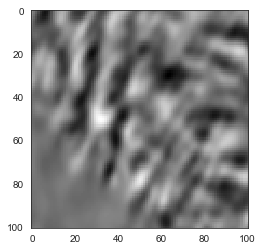

In [9]:
image = read_image("34e51dba6a")
print(image.shape)
plt.imshow(image, cmap="gray")

Information about a mask

(101, 101)


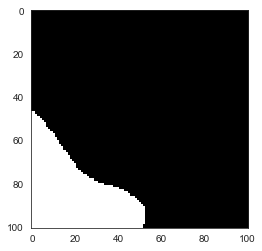

In [10]:
mask = read_mask("34e51dba6a")
print(mask.shape)
plt.imshow(mask, cmap="gray")

Combined plot showing the image with the mask overlayed. Here we can see that there are examples without salt, as you can see by the masks that are entirely dark.

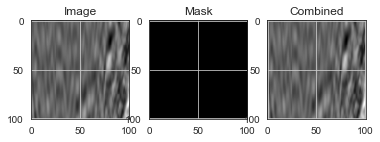

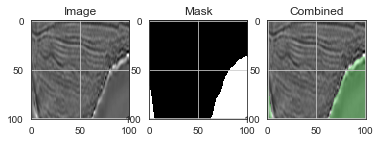

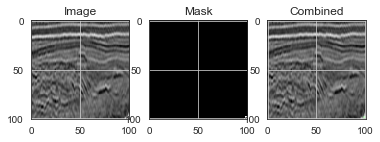

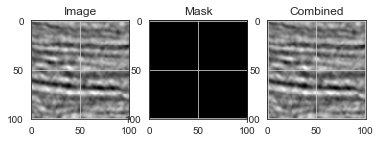

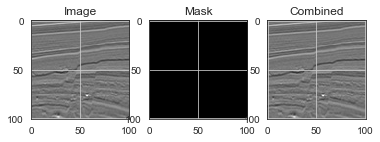

In [11]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
for j, img_name in enumerate(ids):
    img = plot_image_mask(img_name)

## Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [12]:
train_df["images"] = [np.array(load_img(os.path.join(train_images_path, "{}.png").format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

In [13]:
train_df["masks"] = [np.array(load_img(os.path.join(train_masks_path, "{}.png").format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

## Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [14]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [15]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5,0,'Coverage class')

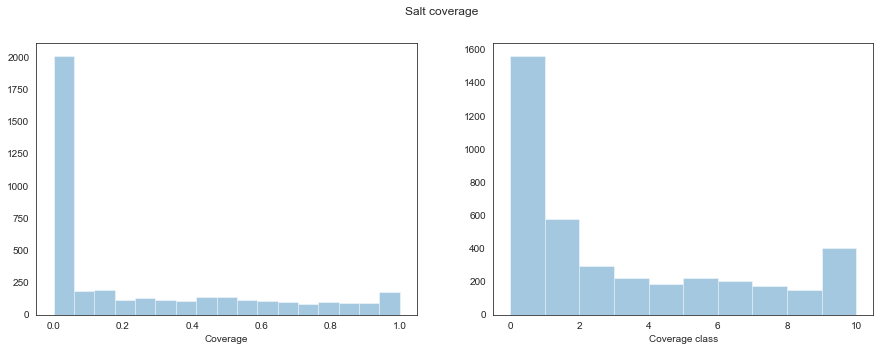

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

## Plot the depth distributions
Separatelty plot the depth distributions for the training and the testing data.

Text(0.5,1,'Depth distribution')

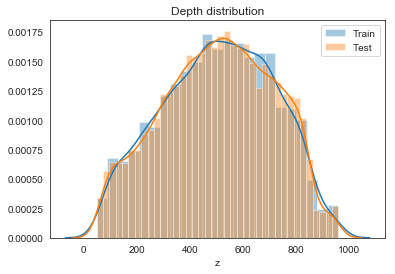

In [19]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

## More Example Images

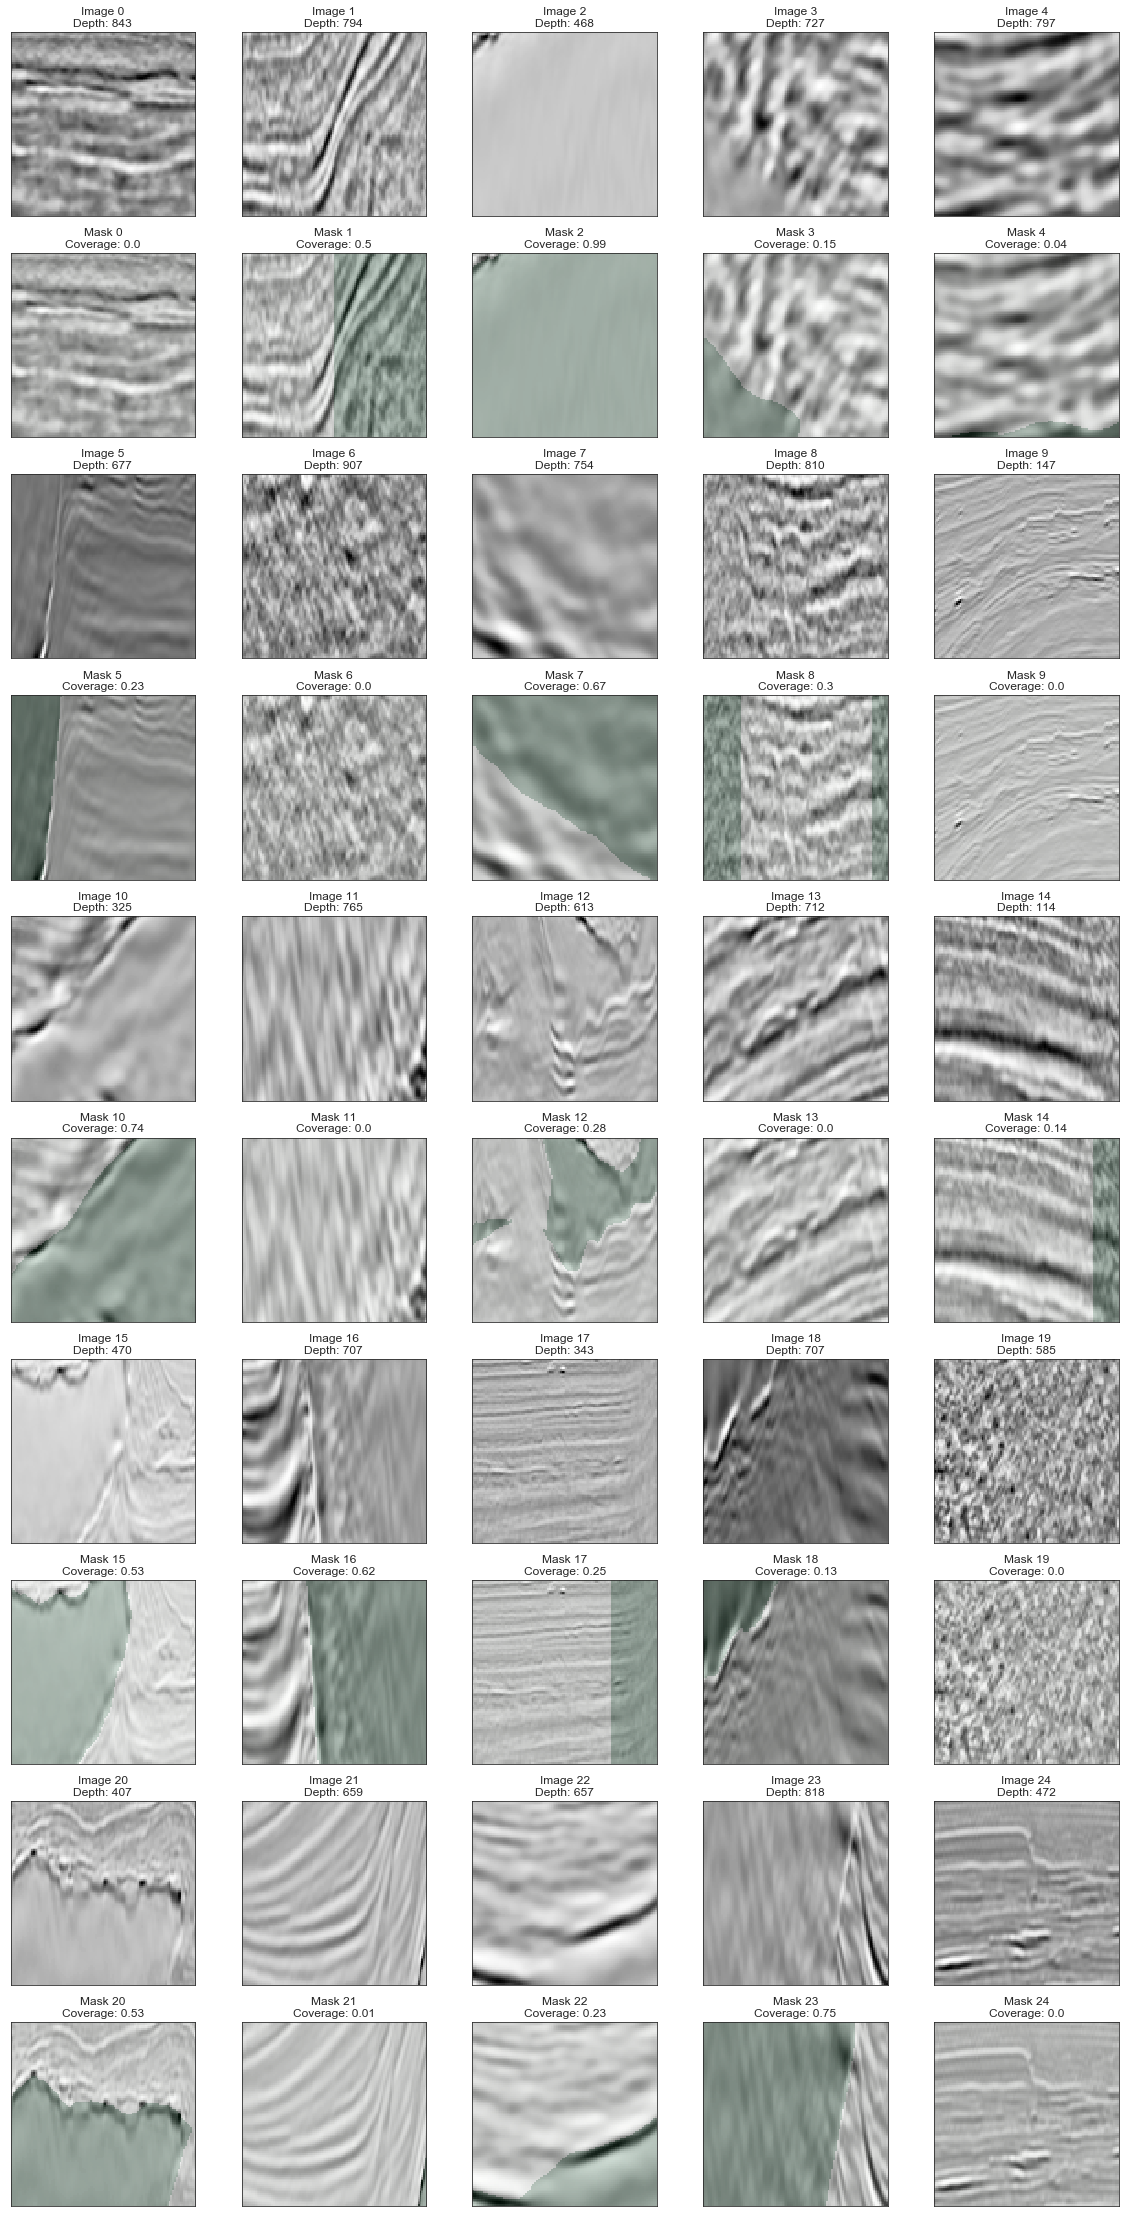

In [20]:
max_images = 25
grid_width = 5
grid_height = int(max_images / grid_width)*2
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax_image = axs[int(i / grid_width)*2, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(i, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*2+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.2, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(i,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])

## Appendix 1 - Environment Configuration

In [17]:
print (os.getcwd())
print (sys.version)
print (sys.executable)
print (sys.path)

D:\Development\DataScience\Learning\Kaggle TGS Salt Identification Challenge\notebooks\eda
3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
c:\applications\miniconda3\envs\tensorflow-gpu\python.exe
['D:\\Development\\DataScience\\Learning\\Kaggle TGS Salt Identification Challenge\\src', '', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\python36.zip', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\DLLs', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib\\site-packages', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\object_detection-0.1-py3.6.egg', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\mark_\\.ipython']


## Appendix 2 - Automated Tests

In [18]:
# Run tests within notebook
f_path = os.getcwd()
os.chdir(os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir)))

# Run pytest from the repository root
!pytest

os.chdir(f_path)

============================= test session starts =============================
platform win32 -- Python 3.6.2, pytest-3.2.1, py-1.4.34, pluggy-0.4.0
rootdir: D:\Development\DataScience\Learning\Kaggle TGS Salt Identification Challenge, inifile:
collected 0 items / 3 errors

=================================== ERRORS ====================================
___________________ ERROR collecting tests/test_notebook.py ___________________
ImportError while importing test module 'D:\Development\DataScience\Learning\Kaggle TGS Salt Identification Challenge\tests\test_notebook.py'.
Hint: make sure your test modules/packages have valid Python names.
Traceback:
tests\test_notebook.py:6: in <module>
    import numpy as np
E   ModuleNotFoundError: No module named 'numpy'
 ERROR collecting tests/examplepackage/examplemodule/test_add_value_to_numpy.py 
ImportError while importing test module 'D:\Development\DataScience\Learning\Kaggle TGS Salt Identification Challenge\tests\examplepackage\examplemodul